# Guideline for how to get started when using data in CSV files

_Maybe some general remarks on working with CSV data in OpenSense?_

## PWS data
This notebook gives an example how to get started using single PWS csv-files. The following exmaples uses a subset data from the AMS dateset published by de Vos et al. (2019). 
PWS data which are dowloaded using the API come as individual csv files and should also include a meta file with PWS IDs and coordinates. 

_@Louise: How does this look like if data are obtained directly form Netatmo?_




In [1]:
import datetime
import glob
import warnings

import numpy as np
import pandas as pd
import xarray as xr
from tqdm import tqdm

warnings.simplefilter(action="ignore", category=FutureWarning)

### Functions for checking data

It is quite frequent, that Netamo PWS have identical coordinates. This indicates that the users have not used the web interface from Netatmo correctly to place their PWS which leads to a false location information. This function is used later on to remove PWS with identical coordinates. 

In [2]:
# Small function to remove PWS with duplicate coordinates from an xarray.Dataset
def get_duplicate_coordinates(ds, id_var_name="id", keep=False, lat="lat", lon="lon"):  # noqa: D103
    # lat and lon can be set if a dataset does not follow our OS cenvention
    df_data = ds[id_var_name].to_dataframe()  # assumes that there is an 'id' dimension
    # return a boolean series which can easily be used for indexing in the initial `ds`
    return df_data.duplicated(subset=[lon, lat], keep=keep)

Netatmo PWS data can have a temporal resolution up to ~5 Min. However, these invervals are not exactly 5 minutes and can occasionally be a bit longer which leads to either missing time stamps in the data series or single timestamps with missing data. The following functions checks for complete time series with NaN for the missing values. Otherwise the missing dates are infilled by reindexing the dataframe.

Note that this function uses specific metadata entries for the AMS PWS dataset. This function works only if all the timestamps start at at full 5 minutes. This needs to be adjusted accordingly for other datasets.

In [3]:
def reindex_timestamps(df_data):  # noqa: D103
    # check if timestamps are complete
    start = df_data.index[0]
    end = df_data.index[-1]
    dates = pd.date_range(start=start, end=end, freq="5Min")
    if len(df_data.index) != len(dates):
        print(f"File {fn} has missing time steps, reindexing")  # noqa: T201
        df_data = df_data.reindex(dates)
    return df_data

### Read CSV raw data file

Let's get a list of the all the raw data files. In the next steps we will use only one file, but later we want to loop through all files.

In [4]:
fn_list = sorted(glob.glob("csv_cookbook_data/ams*.csv"))  # noqa: PTH207
fn_list

['csv_cookbook_data/ams1.csv',
 'csv_cookbook_data/ams2.csv',
 'csv_cookbook_data/ams3.csv',
 'csv_cookbook_data/ams4.csv',
 'csv_cookbook_data/ams5.csv',
 'csv_cookbook_data/ams6.csv',
 'csv_cookbook_data/ams7.csv',
 'csv_cookbook_data/ams8.csv',
 'csv_cookbook_data/ams9.csv']

In [5]:
pws_data = pd.read_csv(fn_list[0], index_col=0, parse_dates=True, sep=",")
pws_data.head()

,ams1
Time,
2016-05-01 00:05:00,0.0
2016-05-01 00:10:00,0.0
2016-05-01 00:15:00,0.0
2016-05-01 00:20:00,0.0
2016-05-01 00:25:00,0.0


### Read in CSV metadata file

In [6]:
# Load metadata from the Amsterdam PWS data set (showcase subset with 9 PWS)
pws_meta = pd.read_csv("csv_cookbook_data/AMS_metadatasubset.csv", sep=",")

In [7]:
pws_meta.head()

,ID,lon,lat
0,ams1,4.670664,52.305896
1,ams2,4.674940,52.302044
2,ams3,4.677275,52.308427
3,ams4,4.677554,52.346013
4,ams5,4.678593,52.318572


### Convert data from `pandas.Dataframe` to `xarray.Dataset` including metadata

The following function converts the `pandas.Dataframe` to `xarray.Dataset` including metadata. This follows the data conventions defined in the OpenSense Cost Action (link to white paper)

Note that this function uses specific metadata entries for the AMS PWS dataset. This needs to be adjusted accordingly for other dataset.

In [8]:
def dataframe_to_dataset(pws_data, lon, lat, elevation=None):  # noqa: D103
    pws_data.index = pws_data.index.rename("time")

    ds = pws_data.to_xarray().to_array(dim="id")

    ds = ds.to_dataset(name="rainfall")

    if elevation is None:
        ds = ds.assign_coords({"elevation": xr.full_like(ds.id, np.nan)})
    else:
        ds = ds.assign_coords({"elevation": elevation})

    ds = ds.assign_coords({"lon": lon})
    ds = ds.assign_coords({"lat": lat})
    # Important: Set the reference, otherwise the first time step is used.
    ds.time.encoding["units"] = "seconds since 1970-01-01 00:00:00"

    # variable attributes
    ds.rainfall.attrs = {
        "name": "rainfall",
        "long_name": "rainfall amount per time unit",
        "units": "mm",
        "coverage_contant_type": "physicalMeasurement",
    }

    # coordiate attributes
    ds.time.attrs = {"unit": "seconds since 1970-01-01 00:00:00"}
    ds.lon.attrs = {"units": "degrees in WGS84 projection"}
    ds.lat.attrs = {"units": "degrees in WGS84 projection"}
    ds.elevation.attrs = {"units": "meters", "longname": "meters_above_sea"}

    # global Atrributes
    ds.attrs["title"] = "PWS data from Amsterdam"
    ds.attrs[
        "institution"
    ] = "Wageningen University and Research, Department of Environmental Sciences"
    ds.attrs["history"] = "Subset of the orignal PWS dataset from de Vos et al. (2019)"
    ds.attrs["references"] = "https://doi.org/10.1029/2019GL083731"
    ds.attrs["date_created"] = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    ds.attrs["Conventions"] = "OpenSense-0.1"
    ds.attrs[
        "license restrictions"
    ] = "CC-BY 4.0 https://creativecommons.org/licenses/by/4.0/"
    ds.attrs["location"] = "Amsterdam (NL)"
    ds.attrs["source"] = "Netatmo PWS"
    ds.attrs["comment"] = ""

    return ds

### Parse raw data and convert to `xarray.Dataset` with metadata

PWS ams1 has single timestamps with missing data, PWS ams2, ams6 and ams7 have empty timestemps (which corresponds to NaN). 

In [9]:
ds_list = []
for _, metadata_row in tqdm(pws_meta.iterrows()):
    fn = f"csv_cookbook_data/{metadata_row.ID}.csv"
    pws_data = pd.read_csv(fn, index_col=0, parse_dates=True, sep=",")
    print(pws_data.index[0])  # noqa: T201

    duplicate_ix = pws_data.index.duplicated(keep=False).sum()
    if duplicate_ix > 0:
        print(str(duplicate_ix) + " duplicate indices in file " + metadata_row.ID)  # noqa: T201
        pws_data = pws_data[~pws_data.index.duplicated(keep="last")]

    # check if timestamps are complete
    # PWS ams1 has single timestamps with missing data,
    # PWS ams2, ams6 and ams7 have empty timestemps (which corresponds to NaN).
    reindex_timestamps(pws_data)

    # replace values smaller than 0 with np.nan
    # This is relevant if PWS have numerical values (e.g. -9999) for NaN
    pws_data[pws_data < 0] = np.nan

    print(  # noqa: T201
        metadata_row.ID,
        "has",
        int(pws_data.isnull().sum()[0] / pws_data.index.shape[0] * 100),  # noqa: PD003
        "% missing values",
    )

    # The follwoing lines convert the data to array and add the attributes
    # accoding to the OpenSense naming conventions
    ds = dataframe_to_dataset(pws_data, metadata_row.lon, metadata_row.lat)
    ds_list.append(ds)

1it [00:00,  7.23it/s]

2016-05-01 00:05:00
File csv_cookbook_data/ams1.csv has missing time steps, reindexing
ams1 has 0 % missing values
2016-05-01 00:05:00
ams2 has 100 % missing values


5it [00:00, 10.61it/s]

2016-05-01 17:30:00
ams3 has 4 % missing values
2016-05-01 00:05:00
ams4 has 1 % missing values
2016-05-01 00:05:00
ams5 has 100 % missing values


7it [00:00, 12.37it/s]

2016-05-01 00:05:00
ams6 has 4 % missing values
2016-05-01 00:05:00
ams7 has 100 % missing values
2016-05-01 00:05:00
ams8 has 100 % missing values
2016-05-01 00:05:00
ams9 has 100 % missing values


9it [00:00, 12.19it/s]


### Concatenate all individual `xarray.Datasets` to one `xarray.Dataset` with all stations

PWS ams8 and ams9 have identical coordinates. These stations will be removed using the fuction defined above when creating one `xarray.Dataset` with all stations 

In [10]:
# write list to one netCDF file
ds_all = xr.concat(ds_list, dim="id")

# remove PWS with duplicate coordinates from xarray.Dataset
duplicates = get_duplicate_coordinates(ds_all, lat="lat", lon="lon")
ds_all = ds_all.sel(id=~duplicates.to_numpy())
print("Dataset has", duplicates.sum(), "PWS with identical lat/lon coordinates")  # noqa: T201

Dataset has 2 PWS with identical lat/lon coordinates


In [11]:
ds_all

<xarray.Dataset>
Dimensions:    (time: 2879, id: 7)
Coordinates:
  * time       (time) datetime64[ns] 2016-05-01T00:05:00 ... 2016-05-10T23:55:00
  * id         (id) object 'ams1' 'ams2' 'ams3' 'ams4' 'ams5' 'ams6' 'ams7'
    elevation  (id) object nan nan nan nan nan nan nan
    lon        (id) float64 4.671 4.675 4.677 4.678 4.679 4.679 4.679
    lat        (id) float64 52.31 52.3 52.31 52.35 52.32 52.3 52.3
Data variables:
    rainfall   (id, time) float64 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
Attributes:
    title:                 PWS data from Amsterdam
    institution:           Wageningen University and Research, Department of ...
    history:               Subset of the orignal PWS dataset from de Vos et a...
    references:            https://doi.org/10.1029/2019GL083731
    date_created:          2024-06-20 16:57:23
    Conventions:           OpenSense-0.1
    license restrictions:  CC-BY 4.0 https://creativecommons.org/licenses/by/...
    location:              Amsterdam (NL)
    source:                Netatmo PWS
    comment:

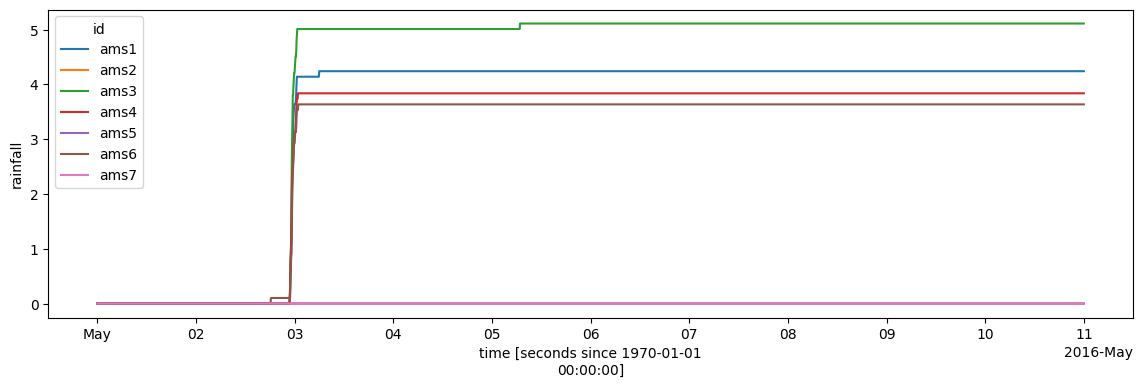

In [12]:
ds_all.rainfall.cumsum(dim="time").plot.line(x="time", figsize=(14, 4));

### Save data to compressed NetCDF

In [13]:
# add enconoding to compress the file
myencoding = {
    "rainfall": {
        "dtype": "int32",
        "scale_factor": 0.001,
        "zlib": True,
        "_FillValue": -9999,
        "complevel": 3,
    }
}

ds_all.to_netcdf("AMS_PWS_subset.nc", encoding=myencoding)

## CML data

### to be added...